In [1]:
from IPython.display import display, Image, Audio

import cv2  # We're using OpenCV to read video
import base64
import time
import openai
import os
import requests

In [2]:
video = cv2.VideoCapture("../data/stack_video.mov")

base64Frames = []
while video.isOpened():
    success, frame = video.read()
    if not success:
        break
    _, buffer = cv2.imencode(".jpg", frame)
    base64Frames.append(base64.b64encode(buffer).decode("utf-8"))

video.release()
print(len(base64Frames), "frames read.")

341 frames read.


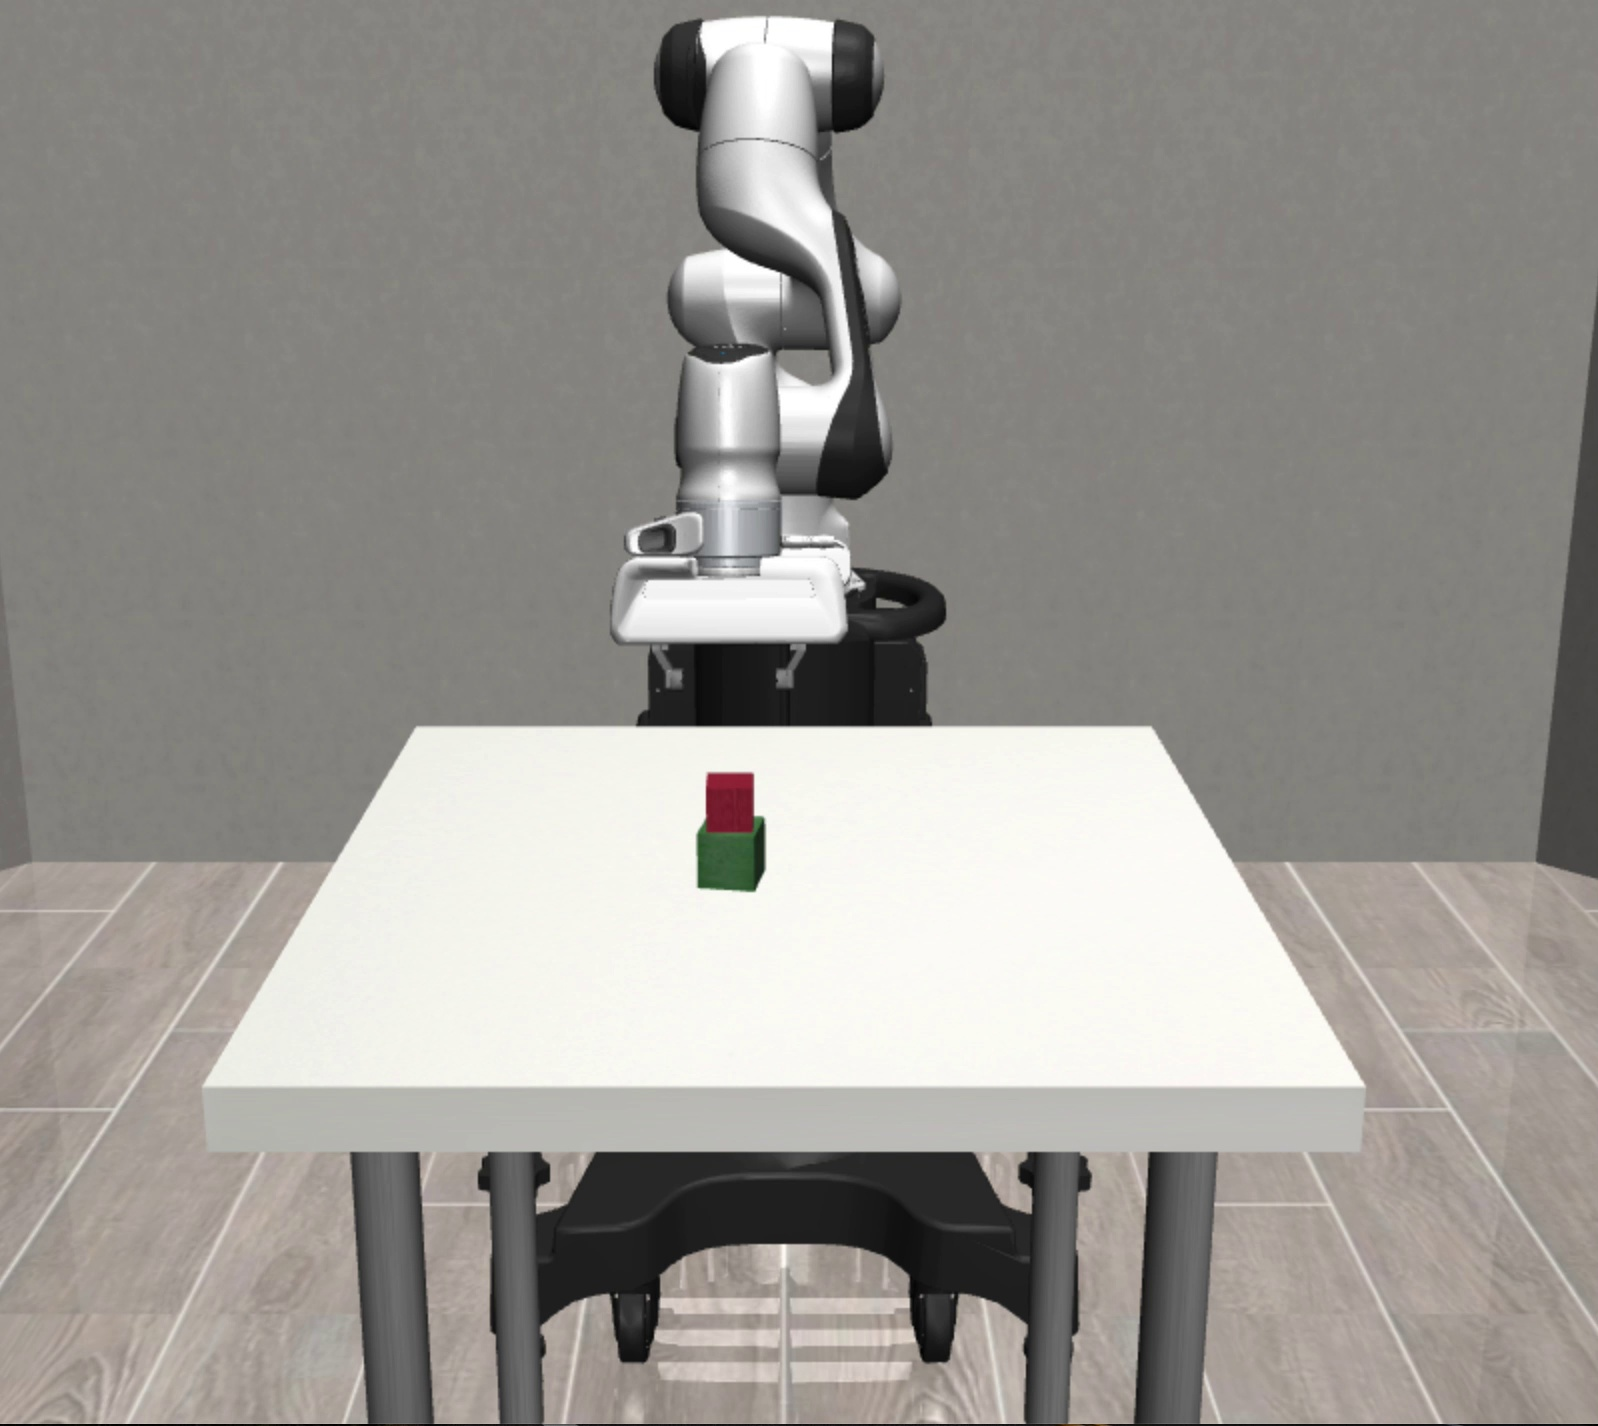

In [7]:
display_handle = display(None, display_id=True)
for img in base64Frames:
    display_handle.update(Image(data=base64.b64decode(img.encode("utf-8"))))
    time.sleep(0.025)

In [5]:
PROMPT = """Your task is to ingest the following data and break down what occurred during the robot episode into hierarchical granular subtasks. Each subtask should be a sequential step that occurred during the robot episode. The simulation step is associated with the frame I'm providing to you. You should identify the start step and end step of each subtask. Create as many granular subtasks as you see in the data.

Use chain of thought to break down the data into subtasks.

Report the list of subtasks as a dictionary with at the beginning of your response:
```
{1: <subtask_name>,
1.1: {'start_step: 1, 'end_step': 10, subtask: '<low level primitive>'},
1.2: {'start_step: 11, 'end_step': 20, subtask: '<low level primitive>'},
2: <subtask_name>,
2.1: {'start_step: 21, 'end_step': 30, subtask: '<low level primitive>'},
...
}
```
Then explain your thoughts.
"""


PROMPT_MESSAGES = [
    {
        "role": "user",
        "content": [PROMPT,
            *map(lambda x: {"image": x, "resize": 480}, base64Frames[0::50]),
        ],
    },
]
params = {
    "model": "gpt-4-vision-preview",
    "messages": PROMPT_MESSAGES,
    "api_key": os.environ["OPENAI_API_KEY"],
    "headers": {"Openai-Version": "2020-11-07"},
    "max_tokens": 200,
}

result = openai.ChatCompletion.create(**params)
print(result.choices[0].message.content)

```
{
1: 'Approach Phase',
1.1: {'start_step': 1, 'end_step': 2, 'subtask': 'Visual identification of objects'},
1.2: {'start_step': 3, 'end_step': 4, 'subtask': 'Positioning for approach'},
2: 'Grasping Phase',
2.1: {'start_step': 5, 'end_step': 6, 'subtask': 'Reach out to the target object'},
2.2: {'start_step': 7, 'end_step': 8, 'subtask': 'Adjust gripper position'},
2.3: {'start_step': 9, 'end_step': 10, 'subtask': 'Close gripper to grasp object'},
3: 'Lift and Place Phase',
3.1: {'start_step': 11, 'end_step': 12, 'subtask': 'Lift the object'},
3


In [6]:
result

<OpenAIObject chat.completion id=chatcmpl-8Ks4XnECpQ4EklPPMJ8jlwOHLQVOo at 0x7fcc0b5189f0> JSON: {
  "choices": [
    {
      "finish_details": {
        "type": "max_tokens"
      },
      "index": 0,
      "message": {
        "content": "```\n{\n1: 'Approach Phase',\n1.1: {'start_step': 1, 'end_step': 2, 'subtask': 'Visual identification of objects'},\n1.2: {'start_step': 3, 'end_step': 4, 'subtask': 'Positioning for approach'},\n2: 'Grasping Phase',\n2.1: {'start_step': 5, 'end_step': 6, 'subtask': 'Reach out to the target object'},\n2.2: {'start_step': 7, 'end_step': 8, 'subtask': 'Adjust gripper position'},\n2.3: {'start_step': 9, 'end_step': 10, 'subtask': 'Close gripper to grasp object'},\n3: 'Lift and Place Phase',\n3.1: {'start_step': 11, 'end_step': 12, 'subtask': 'Lift the object'},\n3",
        "role": "assistant"
      }
    }
  ],
  "created": 1699985105,
  "id": "chatcmpl-8Ks4XnECpQ4EklPPMJ8jlwOHLQVOo",
  "model": "gpt-4-1106-vision-preview",
  "object": "chat.completio